# Node Classification with Graph Convolutional Networks (GCN) on the Cora Dataset


This notebook demonstrates how to perform node classification using Graph Convolutional Networks (GCN) on the Cora dataset. The Cora dataset comprises scientific publications classified into one of seven classes. The goal is to predict the class of each publication, where nodes represent publications, and edges represent citation links.

We will use PyTorch Geometric (PyG), a library built on top of PyTorch for creating graph neural networks. You'll see how to load the dataset, define a GCN model, train the model, and evaluate its performance on classifying the nodes.



### Installation Requirements

Before we start, ensure that you have PyTorch installed. Then, install PyTorch Geometric by following the instructions on their [GitHub page](https://github.com/pyg-team/pytorch_geometric#installation). This might involve installing additional PyTorch Geometric libraries depending on your system.


In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv


### Loading the Dataset

The Cora dataset is easily loaded using PyTorch Geometric's `Planetoid` class. This dataset is automatically downloaded if not present in the specified directory.


In [2]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

### Exploring the Dataset

Let's explore the Cora dataset to understand its structure and the type of information it contains. The Cora dataset is a graph dataset where nodes represent scientific publications, and edges represent citation links between these publications. Each publication (node) is associated with a word vector representing the presence or absence of certain words from a dictionary. The nodes are classified into one of several categories, representing the field of study of the publication.

In [3]:
# Print basic information about the Cora dataset
print(f'Number of Nodes: {dataset[0].num_nodes}')
print(f'Number of Node Features: {dataset.num_node_features}')
print(f'Number of Classes: {dataset.num_classes}')
print(f'Number of Edges: {dataset[0].num_edges}')

# Access the first graph in the dataset
data = dataset[0]

# Check if the graph is undirected
print(f'Is the graph undirected? {data.is_undirected()}')

# Print the features of the first node as a sample
# Convert the features of the first node to integers and then to a list
node_features_as_int_list = data.x[0].int().tolist()

# Print the features of the first node as a list of integer values
print('Features of the first node (as list of integers):\n', node_features_as_int_list)

Number of Nodes: 2708
Number of Node Features: 1433
Number of Classes: 7
Number of Edges: 10556
Is the graph undirected? True
Features of the first node (as list of integers):
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

The list represents a binary word vector for a publication in the Cora dataset, where each element corresponds to a specific word from a predefined dictionary of relevant words. The value 1 indicates the presence of the word in the document, and 0 indicates its absence. This sparse vector encodes the content of the publication, allowing machine learning models to process and learn from textual information in a graph-based framework.

Now that we have a general idea about the dataset let's dive deeper into the graph's structure. We'll look at the node features, edge connections, and how the data is split into training, validation, and test sets. Understanding these aspects is crucial for designing our graph neural network model.

In [4]:
# Explore node features
node_features = data.x
print(f'Shape of node features: {node_features.shape}')
# The shape tells us there are as many rows as nodes in the graph and as many columns as features per node

# Explore the edge index
edge_index = data.edge_index
print(f'Shape of edge index: {edge_index.shape}')
# The shape tells us there are 2 rows (source and target nodes for each edge) and as many columns as there are edges

# Print a small part of the edge index to understand its structure
print('Sample edges:\n', edge_index[:, :6])

Shape of node features: torch.Size([2708, 1433])
Shape of edge index: torch.Size([2, 10556])
Sample edges:
 tensor([[ 633, 1862, 2582,    2,  652,  654],
        [   0,    0,    0,    1,    1,    1]])


... the last line of code prints the first 6 edges from the edge_index tensor (in this case, a matrix) of the graph, showing source and target node pairs for each edge. Each column represents an edge, with the first row for source nodes and the second row for target nodes.

### Plotting the Graph

To better understand the Cora dataset's graph structure, we can visualize it. This visualization will help us see how nodes (publications) are interconnected through edges (citations). For simplicity, given the large size of the Cora graph, we might limit our visualization to a subgraph or use techniques like node sampling.

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert to NetworkX graph from PyTorch Geometric dataset
def to_networkx(data):
    G = nx.Graph()
    edge_index = data.edge_index.numpy()
    edges = zip(edge_index[0], edge_index[1])
    G.add_edges_from(edges)

    return G

# Create a NetworkX graph from the Cora dataset
G = to_networkx(dataset[0])

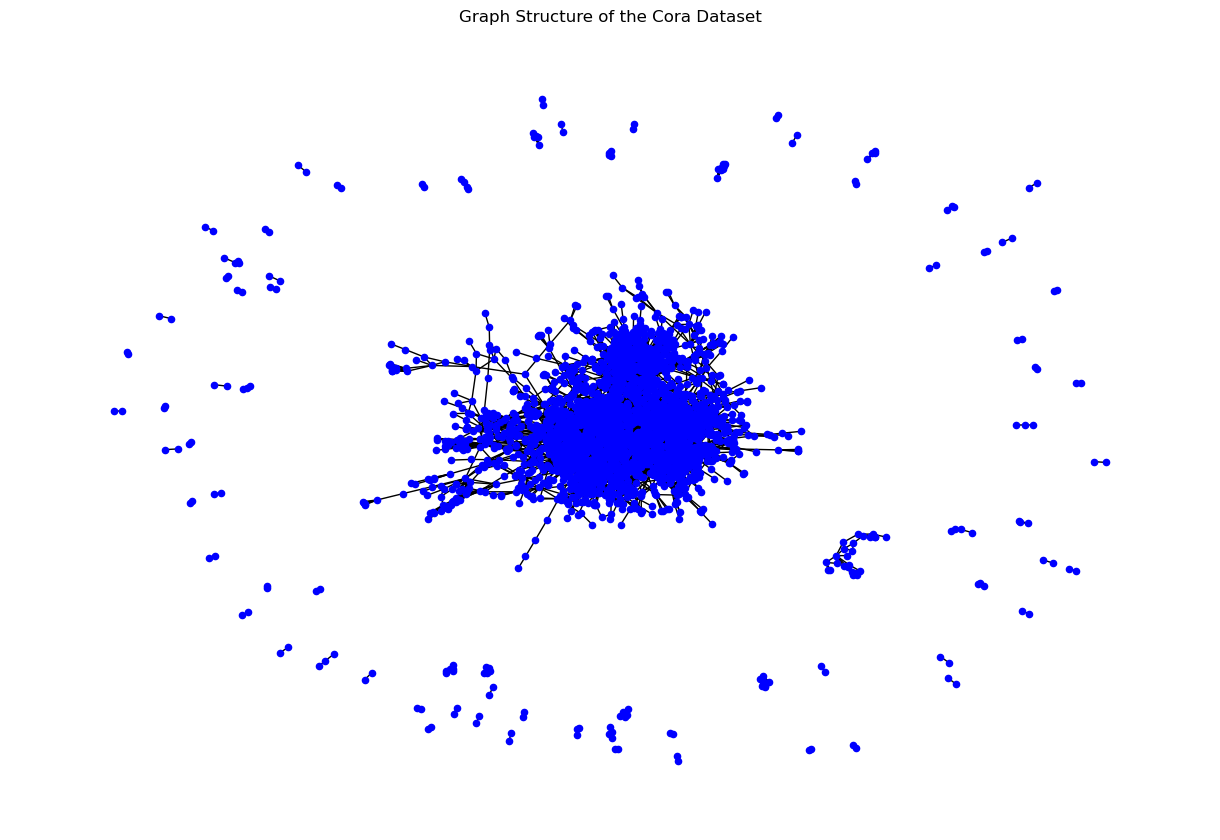

Number of connected components in the graph: 78


In [6]:
# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, node_size=20, node_color='blue', with_labels=False)
plt.title('Graph Structure of the Cora Dataset')
plt.show()

# Compute the number of connected components in the graph
num_connected_components = nx.number_connected_components(G)
print(f'Number of connected components in the graph: {num_connected_components}')

### Dataset Split
In machine learning tasks involving graph data, it's crucial to split the dataset into training, validation, and testing subsets. This separation allows for effective model training, hyperparameter tuning, and evaluation of model performance on unseen data. The provided code snippet demonstrates a method for custom splitting of a graph dataset into approximately 60% training, 20% validation, and 20% testing subsets.

In [7]:
# Calculate the number of nodes for each subset
num_train = int(num_nodes * 0.6)
num_val_test = int(num_nodes * 0.2)  # Approximately 20% for validation and 20% for testing

# Initialize masks for the training, validation, and testing sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Generate a random permutation of all node indices
permuted_indices = torch.randperm(num_nodes)

# Mart the training, validation and testing subsets using boolean masks (train_mask, val_mask, test_mask), which can be used during the model training and evaluation phases to identify which nodes belong to each subset.

# Assign the first 60% of permuted indices to training
train_mask[permuted_indices[:num_train]] = True

# Assign the next 20% of permuted indices to validation
val_mask[permuted_indices[num_train:num_train + num_val_test]] = True

# Assign the last 20% of indices to testing
test_mask[permuted_indices[num_train + num_val_test:]] = True

# Assign the masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Total Nodes: {num_nodes}")
print(f"Training Nodes: {train_mask.sum().item()}")
print(f"Validation Nodes: {val_mask.sum().item()}")
print(f"Testing Nodes: {test_mask.sum().item()}")

NameError: name 'num_nodes' is not defined


### Defining the GCN Model

The GCN model comprises two graph convolutional layers. The first layer transforms node features into intermediate features, and the second layer produces the output for each class. ReLU activation and dropout are applied for non-linearity and regularization, respectively.


In [ ]:
# Define a Graph Convolutional Network (GCN) class that inherits from torch.nn.Module

# Initialize the GCN class
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()

        # Define the first graph convolutional layer (conv1). This layer will transform the input node features (with dimension equal to num_features) to hidden node features of dimension 16. The first parameter is the size of each input sample, and the second parameter is the size of each output sample.

        self.conv1 = GCNConv(num_features, 16)

        # Define the second graph convolutional layer (conv2). This layer transforms the hidden node features from the previous layer (with dimension 16) to the size of the output classes (num_classes). This prepares the output for each node to be in the space of the class labels.

        self.conv2 = GCNConv(16, num_classes)

    # Define the forward pass for the network. The forward pass defines how the input data (data) flows through the network.
    
    def forward(self, data):
        # Extract node features (x) and the edge index (edge_index) from the input data. The edge index is a list of vertex pairs, representing the graph's edges.
        
        x, edge_index = data.x, data.edge_index

        # Apply the first graph convolutional layer. This operation takes the node features and the graph structure (via edge_index) and applies the convolutional transformation to compute new node features.
        
        x = self.conv1(x, edge_index)

        # Apply the ReLU activation function to introduce non-linearity into the model, enabling it to learn more complex patterns.
        
        x = F.relu(x)

        # Apply dropout to the features to prevent overfitting. During training, random neurons are "dropped out" (i.e., set to zero) based on a certain probability (default is 0.5). This is only done during training, not during evaluation, hence the `training=self.training` condition.
        
        x = F.dropout(x, training=self.training)

        # Apply the second graph convolutional layer to transform the features to the final output size, which corresponds to the number of classes.
        
        x = self.conv2(x, edge_index)

        # Apply the log softmax activation to the output of the second convolutional layer. This normalizes the output to a probability distribution over classes for each node, and applies a logarithm for numerical stability and to prepare for the NLL (negative log likelihood) loss.
        
        return F.log_softmax(x, dim=1)


### Initializing the Model and Training

Once the GCN model is defined, it needs to be instantiated, and an optimizer must be selected for the training process. The training loop iterates over the dataset, applying the forward pass of the model, computing the loss, and updating the model parameters based on the training subset. We use the Adam optimizer with a learning rate of 0.01 and a weight decay of 5e-4. The model is trained for 200 epochs, and the loss is printed at each epoch.


In [ ]:
import matplotlib.pyplot as plt

# 'dataset' is your dataset object and 'data' is the graph data object
# Check if a GPU is available and if so, use it; otherwise, use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the GCN model. 'num_features' is the dimensionality of the input features per node, and 'num_classes' is the number of classes for classification.

model = GCN(num_features=dataset.num_node_features, num_classes=dataset.num_classes).to(device)

# Choose the ADAM optimizer for training the model. 'lr' is the learning rate and 'weight_decay' is a regularization term.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Prepare a list to save the value of the loss at each epoch, for later visualization
loss_values = []

# Training loop
model.train()
for epoch in range(200):  # Number of epochs
    optimizer.zero_grad()  # Clear gradients for the next train
    out = model(data.to(device))  # Perform a single forward pass
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute the loss only on the training nodes
    loss.backward()  # Perform backpropagation
    optimizer.step()  # Update model parameters

    # Save the current loss so we can plot it later
    loss_values.append(loss.item())

    # Print the loss every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss {loss.item()}')

# Plotting the evolution of the loss as a function of the epochs
plt.figure(figsize=(10, 6))
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Optimization

To perform hyperparameter tuning for optimizing the number of layers and the dimension of hidden node features in a Graph Convolutional Network (GCN), we will follow a grid search approach. We will iterate over a range of values for both the number of layers and hidden feature dimensions, train the model for each combination on the training set, and evaluate it on the validation set to find the combination that results in the best validation performance.

First, modify the GCN model to support a variable number of layers and hidden feature dimensions.

In [ ]:
# Define a flexible Graph Convolutional Network (GCN) class that can vary in depth and width.
class FlexibleGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_dim=16, num_layers=2):
        super(FlexibleGCN, self).__init__()
        self.layers = torch.nn.ModuleList()  # Initialize a list to hold the GCN layers

        # First layer
        self.layers.append(GCNConv(num_features, hidden_dim))

        # Intermediate layers: all using the same dimension
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_dim, hidden_dim))

        # Output layer
        self.layers.append(GCNConv(hidden_dim, num_classes))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # Extract node features and the graph connectivity

        # Process through each layer except the last one
        for layer in self.layers[:-1]:
            x = F.relu(layer(x, edge_index))  # Apply graph convolution followed by ReLU activation
            x = F.dropout(x, training=self.training)  # Apply dropout during training

        # Last layer (without ReLU activation)
        x = self.layers[-1](x, edge_index)

        # Apply log softmax to compute log probabilities
        return F.log_softmax(x, dim=1)

Next, iterate over possible values for num_layers and hidden_dim, training and validating each configuration.

In [ ]:
# Define ranges of hyperparameters for exploration
num_layers_options = [2, 3, 4]  # Number of layers in the GCN
hidden_dim_options = [8, 16, 32]  # Dimensionality of hidden layers

best_val_accuracy = 0  # Initialize the best validation accuracy
best_params = {}  # Dictionary to store the best parameters

# Iterate over all combinations of hyperparameters
for num_layers in num_layers_options:
    for hidden_dim in hidden_dim_options:
        # Initialize the GCN model with the current set of hyperparameters
        
        model = FlexibleGCN(num_features=dataset.num_node_features, num_classes=dataset.num_classes, hidden_dim=hidden_dim, num_layers=num_layers).to(device)

        # Use Adam optimizer with a learning rate of 0.01 and weight decay of 5e-4
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        # Train the model
        model.train()
        for epoch in range(200):
            optimizer.zero_grad()  # Clear previous gradients
            out = model(data.to(device))  # Forward pass: compute the output
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute loss on training nodes
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update model weights

        # Evaluate the model on the validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            pred = model(data.to(device)).argmax(dim=1)  # Predictions
            correct = pred[data.val_mask] == data.y[data.val_mask]  # Correct predictions
            val_accuracy = int(correct.sum()) / int(data.val_mask.sum())  # Calculate accuracy

        # Log the current hyperparameters and their validation accuracy
        print(f'Num Layers: {num_layers}, Hidden Dim: {hidden_dim}, Val Accuracy: {val_accuracy}')

        # Update the best hyperparameters if the current model performs better
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_params = {'num_layers': num_layers, 'hidden_dim': hidden_dim}

# Print out the best hyperparameters and the corresponding validation accuracy
print(f'Best Hyperparameters: {best_params}, Best Validation Accuracy: {best_val_accuracy}')



### Testing the Model with Best Hyperparameters

After identifying the best hyperparameters for our Graph Convolutional Network (GCN) through validation, the final step is to evaluate the model's performance on the test subset. This gives us an unbiased estimate of the model's performance on unseen data, providing insight into how well our model is expected to perform in real-world scenarios or on new, similar data.

The following code provides a step-by-step commentary through the process of retraining the GCN model with the best hyperparameters found during validation (using the training subset), followed by evaluating its performance on the test subset.


In [ ]:
# Initialize the best model using the optimal hyperparameters found during the tuning process. 'best_params' contains the 'hidden_dim' and 'num_layers' that resulted in the best validation performance.
best_model = FlexibleGCN(num_features=dataset.num_node_features,
                         num_classes=dataset.num_classes,
                         hidden_dim=best_params['hidden_dim'],
                         num_layers=best_params['num_layers']).to(device)

# Initialize the ADAM optimizer to update the model's weights
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.01, weight_decay=5e-4)  # Includes learning rate and weight decay for regularization

# Train the model with the best hyperparameters based on the training data.
best_model.train()  # Sets the model in training mode (enables dropout, etc.)
for epoch in range(200):  # Iterates over the dataset for 200 epochs to train the model
    optimizer.zero_grad()  # Clears old gradients from the last step (otherwise they would accumulate)
    out = best_model(data.to(device))  # Performs a forward pass through the model
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Calculates the loss between the output and true labels for the training set
    loss.backward()  # Performs backpropagation, calculating gradients of the loss with respect to model parameters
    optimizer.step()  # Updates model parameters based on the current gradients

# Evaluate the model's performance on the test subset to estimate how well it generalizes to unseen data.
best_model.eval()  # Sets the model in evaluation mode (no dropout)
with torch.no_grad():  # Disables gradient calculation (no needed for model evaluation)
    test_pred = best_model(data.to(device)).argmax(dim=1)  # Predictions for the test set
    correct = test_pred[data.test_mask] == data.y[data.test_mask]  # Checks which predictions match the true labels
    test_accuracy = int(correct.sum()) / int(data.test_mask.sum())  # Calculates the accuracy of the model on the test set

# Prints out the accuracy of the model on the test set, giving an indication of its generalization ability
print(f"Test Accuracy with Best Hyperparameters: {test_accuracy:.4f}")